# 对官方发布的baseline进行学习

## Import dependency（需要的环境依赖）
- Python3
- pandas
- scikit-learn
- rdkit

In [ ]:
!pip install pandas
!pip install -U scikit-learn
!pip install rdkit

In [ ]:
# 首先，导入库
import pickle
import pandas as pd
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from rdkit.Chem import rdMolDescriptors
from rdkit import RDLogger,Chem
import numpy as np
RDLogger.DisableLog('rdApp.*')

# 特征提取
官方发布的数据是对化学分子的SMILES表达式，具体来说，有rxnid,Reactant1,Reactant2,Product,Additive,Solvent,Yield字段。其中：
 - rxnid 对数据的id标识，无实际意义
 - Reactant1 反应物1
 - Reactant2 反应物2
 - Product 产物
 - Additive 添加剂（包括催化剂catalyst等辅助反应物合成但是不对产物贡献原子的部分）
 - Solvent 溶剂
 - Yield 产率
其中Reactant1,Reactant2,Product,Additive,Solvent都是由SMILES表示。

### SMILES
SMILES,全称是Simplified Molecular Input Line Entry System，是一种将化学分子用ASCII字符表示的方法，是化学信息学领域非常重要的工具。

表1：一些常见的化学结构用SMILES表示。  
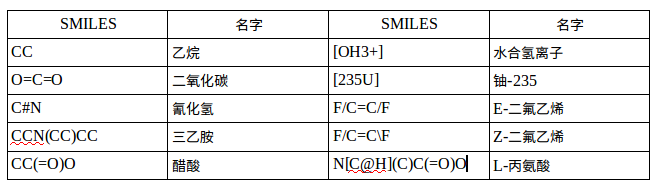

表2：化学反应也可以用SMILES表示，用“>>”连接产物即可。  
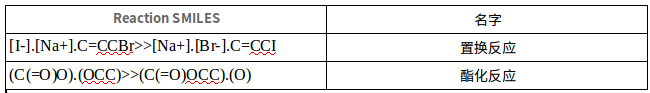

由于Reactant1,Reactant2,Product,Additive,Solvent都是由SMILES表示。所以，可以使用rdkit工具直接提取SMILES的分子指纹（向量），作为特征。

### Morgan fingerprint
位向量（bit ector）形式的特征，即由0,1组成的向量。

### RDKit
化学信息学中主要的工具，开源。网址：http://www.rdkit.org，支持WIN\MAC\Linux，可以被python、Java、C调用。几乎所有的与化学信息学相关的内容都可以在上面找到。


In [ ]:
def mfgen(mol,nBits=2048, radius=2):
    '''
    Parameters
    ----------
    mol : mol
        RDKit mol object.
    nBits : int
        Number of bits for the fingerprint.
    radius : int
        Radius of the Morgan fingerprint.
    Returns
    -------
    mf_desc_map : ndarray
        ndarray of molecular fingerprint descriptors.
    '''
    # 返回分子的位向量形式的Morgan fingerprint
    fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol,radius=radius,nBits=nBits)
    return np.array(list(map(eval,list(fp.ToBitString()))))

# 加载数据
def vec_cpd_lst(smi_lst):
    smi_set = list(set(smi_lst))
    smi_vec_map = {}
    for smi in tqdm(smi_set): # tqdm：显示进度条
        mol = Chem.MolFromSmiles(smi)
        smi_vec_map[smi] = mfgen(mol)
    smi_vec_map[''] = np.zeros(2048)
    
    vec_lst = [smi_vec_map[smi] for smi in smi_lst]
    return np.array(vec_lst)

## Vectorization

In [ ]:
dataset_dir = '../dataset'   # # 注：如果是在AI Studio上，将这里改为'dataset'

train_df = pd.read_csv(f'{dataset_dir}/round1_train_data.csv')
test_df = pd.read_csv(f'{dataset_dir}/round1_test_data.csv')

print(f'Training set size: {len(train_df)}, test set size: {len(test_df)}')

In [ ]:
# 从csv中读取数据
train_rct1_smi = train_df['Reactant1'].to_list()
train_rct2_smi = train_df['Reactant2'].to_list()
train_add_smi = train_df['Additive'].to_list()
train_sol_smi = train_df['Solvent'].to_list()

# 将SMILES转化为分子指纹
train_rct1_fp = vec_cpd_lst(train_rct1_smi)
train_rct2_fp = vec_cpd_lst(train_rct2_smi)
train_add_fp = vec_cpd_lst(train_add_smi)
train_sol_fp = vec_cpd_lst(train_sol_smi)
# 在dim=1维度进行拼接。即：将一条数据的Reactant1,Reactant2,Product,Additive,Solvent字段的morgan fingerprint拼接为一个向量。
train_x = np.concatenate([train_rct1_fp,train_rct2_fp,train_add_fp,train_sol_fp],axis=1)
train_y = train_df['Yield'].to_numpy()

# 测试集也进行同样的操作
test_rct1_smi = test_df['Reactant1'].to_list()
test_rct2_smi = test_df['Reactant2'].to_list()
test_add_smi = test_df['Additive'].to_list()
test_sol_smi = test_df['Solvent'].to_list()

test_rct1_fp = vec_cpd_lst(test_rct1_smi)
test_rct2_fp = vec_cpd_lst(test_rct2_smi)
test_add_fp = vec_cpd_lst(test_add_smi)
test_sol_fp = vec_cpd_lst(test_sol_smi)
test_x = np.concatenate([test_rct1_fp,test_rct2_fp,test_add_fp,test_sol_fp],axis=1)

## Model fitting and saving
使用随机森林进行建模。

### sklearn (scikit-learn)
是一个非常广泛使用的开源机器学习库，基于Python，建立在NumPy、SciPy、Pandas和Matplotlib等数据处理和分析的库之上。  
它涵盖了几乎所有主流机器学习算法，包括分类、回归、聚类、降维等。API设计亲民，整个使用简单易上手，非常适合作为机器学习入门的工具。
官网：https://scikit-learn.org/stable/index.html

在sklearn中，几乎所有的机器学习的流程是：
1. 实例化模型（并指定重要参数）；
2. model.fit(x, y) 训练模型；

### 随机森林
参数解释：
 - n_estimators=10： 决策树的个数，越多越好；但是越多意味着计算开销越大；
 - max_depth: (default=None)设置树的最大深度，默认为None；
 - min_samples_split: 根据属性划分节点时，最少的样本数；
 - min_samples_leaf: 叶子节点最少的样本数；
 - n_jobs=1： 并行job个数，-1表示使用所有cpu进行并行计算。

In [ ]:
# Model fitting
model = RandomForestRegressor(n_estimators=10,max_depth=10,min_samples_split=2,min_samples_leaf=1,n_jobs=-1) # 实例化模型，并指定重要参数
model.fit(train_x,train_y) # 训练模型

In [ ]:
# 保存模型
with open('./random_forest_model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [ ]:
# 加载模型
with open('random_forest_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [ ]:
# 预测\推理
test_pred = loaded_model.predict(test_x)

## 生成赛题要求的submit文件

In [ ]:
ans_str_lst = ['rxnid,Yield']
for idx,y in enumerate(test_pred):
    ans_str_lst.append(f'test{idx+1},{y:.4f}')
with open('./submit.txt','w') as fw:
    fw.writelines('\n'.join(ans_str_lst))